🧠 Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from transformers import CLIPModel, CLIPProcessor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torchvision import models

d:\Programming\Cancer_Detection_Model\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


🧩 Step 2: Define Transformations

Transformations help resize images and normalize them for training.

In [4]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
# VGG16 requires specific ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize all images to same size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Training", transform=transform)
test_dataset=datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Testing", transform=transform)


# Class names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
print(train_dataset.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [6]:
# import random
# import numpy as np

# # Pick 9 random images
# fig, axes = plt.subplots(3, 3, figsize=(8, 8))
# for i in range(9):
#     idx = random.randint(0, len(train_dataset)-1)
#     img, label = train_dataset[idx]
    
#     # Tensor → Numpy for plotting
#     img = img.permute(1, 2, 0).numpy()
    
#     ax = axes[i//3, i%3]
#     ax.imshow(img)
#     ax.set_title(classes[label])
#     ax.axis("off")

# plt.tight_layout()
# plt.show()



In [7]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


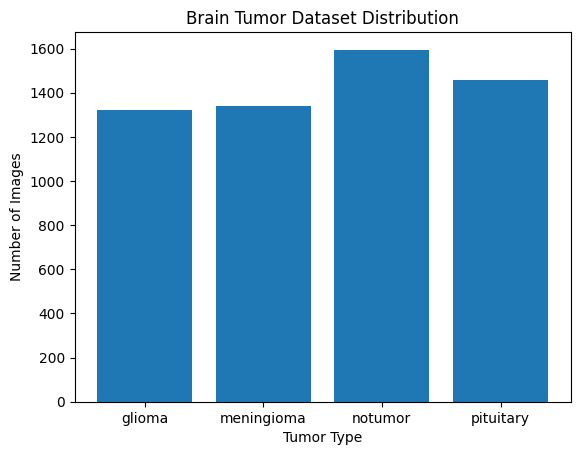

In [8]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


📦 Step 3: Make Datasets class

In [9]:
from torch.utils.data import DataLoader ,Dataset
from sklearn.model_selection import train_test_split



class CustomImageDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img, label = self.image_folder[idx]
        img = self.transform(img)
        return img, label

⚙️ Step 4: Create Dataloaders

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 # You can adjust this

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

print(f"Train loader: {len(train_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

Train loader: 179 batches
Test loader: 41 batches


In [11]:
# # Load pre-trained VGG16 model
# model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# # 1. Freeze the feature-extracting layers (convolutional base)
# for param in model.features.parameters():
#     param.requires_grad = False

# # 2. Replace the final classifier layer
# # VGG16's classifier[6] is nn.Linear(4096, 1000)
# # We replace it with a new layer for our 4 classes
# num_features = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_features, 4)

# # Move the model to the GPU
# model = model.to(device)

# print("VGG16 model loaded and final layer replaced.")
# # print(model.classifier) # Uncomment to see the new classifier structure

🧩 Step 5: Make Model Convolutional Neural Neteork

In [3]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:
NUM_CLASSES = len(classes)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 4


In [5]:
model = CNN(input_channels=3)
model.to(device)


NameError: name 'device' is not defined

In [25]:
from torch import optim

# Define hyperparameters
epochs = 100
# learning_rate = 0.001

# Loss function
criterion = nn.CrossEntropyLoss()

#criterion = nn.CrossEntropyLoss()   # correct for multi-class
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [26]:
from tqdm import tqdm

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for batch_features, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    avg_train_loss = total_epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_features, val_labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            val_features = val_features.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_features)
            v_loss = criterion(val_outputs, val_labels)

            val_loss += v_loss.item()

            _, v_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (v_predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
          f"- Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.11it/s]


Epoch [1/100] - Train Loss: 0.2514, Train Acc: 90.67% - Val Loss: 0.2096, Val Acc: 93.52%


Epoch 2/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.98it/s]


Epoch [2/100] - Train Loss: 0.2270, Train Acc: 91.21% - Val Loss: 0.1675, Val Acc: 94.66%


Epoch 3/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.11it/s]


Epoch [3/100] - Train Loss: 0.2148, Train Acc: 91.14% - Val Loss: 0.1991, Val Acc: 94.66%


Epoch 4/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.18it/s]


Epoch [4/100] - Train Loss: 0.1979, Train Acc: 91.86% - Val Loss: 0.2144, Val Acc: 94.36%


Epoch 5/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.20it/s]


Epoch [5/100] - Train Loss: 0.2172, Train Acc: 91.37% - Val Loss: 0.1972, Val Acc: 93.82%


Epoch 6/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.05it/s]


Epoch [6/100] - Train Loss: 0.2244, Train Acc: 91.16% - Val Loss: 0.1697, Val Acc: 95.27%


Epoch 7/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.06it/s]


Epoch [7/100] - Train Loss: 0.2114, Train Acc: 91.75% - Val Loss: 0.1786, Val Acc: 94.51%


Epoch 8/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.03it/s]


Epoch [8/100] - Train Loss: 0.2098, Train Acc: 91.56% - Val Loss: 0.2018, Val Acc: 94.58%


Epoch 9/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.10it/s]


Epoch [9/100] - Train Loss: 0.2178, Train Acc: 91.39% - Val Loss: 0.1864, Val Acc: 95.27%


Epoch 10/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.18it/s]


Epoch [10/100] - Train Loss: 0.2099, Train Acc: 92.14% - Val Loss: 0.2257, Val Acc: 93.36%


Epoch 11/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.11it/s]


Epoch [11/100] - Train Loss: 0.1911, Train Acc: 92.12% - Val Loss: 0.1730, Val Acc: 95.65%


Epoch 12/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.07it/s]


Epoch [12/100] - Train Loss: 0.2008, Train Acc: 91.72% - Val Loss: 0.1619, Val Acc: 94.74%


Epoch 13/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.02it/s]


Epoch [13/100] - Train Loss: 0.1985, Train Acc: 92.56% - Val Loss: 0.1506, Val Acc: 95.80%


Epoch 14/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.76it/s]


Epoch [14/100] - Train Loss: 0.1970, Train Acc: 91.96% - Val Loss: 0.1927, Val Acc: 93.52%


Epoch 15/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.37it/s]


Epoch [15/100] - Train Loss: 0.2159, Train Acc: 91.40% - Val Loss: 0.1568, Val Acc: 94.36%


Epoch 16/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.66it/s]


Epoch [16/100] - Train Loss: 0.2105, Train Acc: 91.91% - Val Loss: 0.2251, Val Acc: 92.68%


Epoch 17/100 [Val]: 100%|██████████| 41/41 [00:09<00:00,  4.55it/s]


Epoch [17/100] - Train Loss: 0.1889, Train Acc: 92.02% - Val Loss: 0.1671, Val Acc: 95.04%


Epoch 18/100 [Val]: 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


Epoch [18/100] - Train Loss: 0.2099, Train Acc: 91.95% - Val Loss: 0.1583, Val Acc: 95.12%


Epoch 19/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.89it/s]


Epoch [19/100] - Train Loss: 0.1936, Train Acc: 92.47% - Val Loss: 0.2549, Val Acc: 92.45%


Epoch 20/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.78it/s]


Epoch [20/100] - Train Loss: 0.2020, Train Acc: 91.46% - Val Loss: 0.1681, Val Acc: 95.73%


Epoch 21/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.86it/s]


Epoch [21/100] - Train Loss: 0.1800, Train Acc: 92.82% - Val Loss: 0.1808, Val Acc: 95.96%


Epoch 22/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.86it/s]


Epoch [22/100] - Train Loss: 0.2014, Train Acc: 91.91% - Val Loss: 0.1846, Val Acc: 95.12%


Epoch 23/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.84it/s]


Epoch [23/100] - Train Loss: 0.1936, Train Acc: 92.28% - Val Loss: 0.1767, Val Acc: 95.19%


Epoch 24/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.99it/s]


Epoch [24/100] - Train Loss: 0.2009, Train Acc: 92.10% - Val Loss: 0.1821, Val Acc: 94.66%


Epoch 25/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.94it/s]


Epoch [25/100] - Train Loss: 0.1857, Train Acc: 92.70% - Val Loss: 0.1999, Val Acc: 95.27%


Epoch 26/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.83it/s]


Epoch [26/100] - Train Loss: 0.1931, Train Acc: 92.12% - Val Loss: 0.1740, Val Acc: 96.34%


Epoch 27/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.03it/s]


Epoch [27/100] - Train Loss: 0.1824, Train Acc: 92.51% - Val Loss: 0.1484, Val Acc: 94.81%


Epoch 28/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.19it/s]


Epoch [28/100] - Train Loss: 0.1971, Train Acc: 92.12% - Val Loss: 0.1907, Val Acc: 95.50%


Epoch 29/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.10it/s]


Epoch [29/100] - Train Loss: 0.1872, Train Acc: 92.77% - Val Loss: 0.1640, Val Acc: 95.65%


Epoch 30/100 [Val]: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]


Epoch [30/100] - Train Loss: 0.1866, Train Acc: 92.47% - Val Loss: 0.1655, Val Acc: 96.26%


Epoch 31/100 [Val]: 100%|██████████| 41/41 [00:17<00:00,  2.29it/s]


Epoch [31/100] - Train Loss: 0.1859, Train Acc: 92.42% - Val Loss: 0.1796, Val Acc: 96.41%


Epoch 32/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.05it/s]


Epoch [32/100] - Train Loss: 0.1811, Train Acc: 92.44% - Val Loss: 0.1389, Val Acc: 95.58%


Epoch 33/100 [Val]: 100%|██████████| 41/41 [00:24<00:00,  1.68it/s]


Epoch [33/100] - Train Loss: 0.1996, Train Acc: 91.67% - Val Loss: 0.1738, Val Acc: 95.88%


Epoch 34/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.10it/s]


Epoch [34/100] - Train Loss: 0.1676, Train Acc: 93.01% - Val Loss: 0.1488, Val Acc: 96.41%


Epoch 35/100 [Val]: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


Epoch [35/100] - Train Loss: 0.1883, Train Acc: 92.38% - Val Loss: 0.1829, Val Acc: 94.36%


Epoch 36/100 [Val]: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s]


Epoch [36/100] - Train Loss: 0.1674, Train Acc: 93.38% - Val Loss: 0.1239, Val Acc: 96.64%


Epoch 37/100 [Val]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch [37/100] - Train Loss: 0.1807, Train Acc: 92.75% - Val Loss: 0.2353, Val Acc: 92.91%


Epoch 38/100 [Val]: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


Epoch [38/100] - Train Loss: 0.1713, Train Acc: 93.10% - Val Loss: 0.1609, Val Acc: 95.88%


Epoch 39/100 [Val]: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]


Epoch [39/100] - Train Loss: 0.1713, Train Acc: 92.94% - Val Loss: 0.1606, Val Acc: 96.11%


Epoch 40/100 [Val]: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


Epoch [40/100] - Train Loss: 0.1781, Train Acc: 92.63% - Val Loss: 0.1253, Val Acc: 96.26%


Epoch 41/100 [Val]: 100%|██████████| 41/41 [00:22<00:00,  1.79it/s]


Epoch [41/100] - Train Loss: 0.1661, Train Acc: 93.45% - Val Loss: 0.1873, Val Acc: 94.58%


Epoch 42/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.08it/s]


Epoch [42/100] - Train Loss: 0.1697, Train Acc: 93.12% - Val Loss: 0.1364, Val Acc: 96.19%


Epoch 43/100 [Val]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch [43/100] - Train Loss: 0.1670, Train Acc: 92.98% - Val Loss: 0.1684, Val Acc: 95.65%


Epoch 44/100 [Val]: 100%|██████████| 41/41 [00:23<00:00,  1.73it/s]


Epoch [44/100] - Train Loss: 0.1803, Train Acc: 92.96% - Val Loss: 0.1815, Val Acc: 96.49%


Epoch 45/100 [Val]: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]


Epoch [45/100] - Train Loss: 0.1639, Train Acc: 92.86% - Val Loss: 0.1396, Val Acc: 96.87%


Epoch 46/100 [Val]: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]


Epoch [46/100] - Train Loss: 0.1713, Train Acc: 92.79% - Val Loss: 0.1265, Val Acc: 96.26%


Epoch 47/100 [Val]: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]


Epoch [47/100] - Train Loss: 0.1874, Train Acc: 92.84% - Val Loss: 0.1474, Val Acc: 96.26%


Epoch 48/100 [Val]: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s]


Epoch [48/100] - Train Loss: 0.1662, Train Acc: 93.36% - Val Loss: 0.1491, Val Acc: 96.19%


Epoch 49/100 [Val]: 100%|██████████| 41/41 [00:21<00:00,  1.95it/s]


Epoch [49/100] - Train Loss: 0.1750, Train Acc: 92.51% - Val Loss: 0.1298, Val Acc: 96.95%


Epoch 50/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


Epoch [50/100] - Train Loss: 0.1591, Train Acc: 93.33% - Val Loss: 0.1541, Val Acc: 96.49%


Epoch 51/100 [Val]: 100%|██████████| 41/41 [00:22<00:00,  1.83it/s]


Epoch [51/100] - Train Loss: 0.1519, Train Acc: 93.89% - Val Loss: 0.1306, Val Acc: 96.80%


Epoch 52/100 [Val]: 100%|██████████| 41/41 [00:25<00:00,  1.63it/s]


Epoch [52/100] - Train Loss: 0.1399, Train Acc: 94.29% - Val Loss: 0.1873, Val Acc: 96.11%


Epoch 53/100 [Val]: 100%|██████████| 41/41 [00:24<00:00,  1.65it/s]


Epoch [53/100] - Train Loss: 0.1612, Train Acc: 93.29% - Val Loss: 0.1503, Val Acc: 96.26%


Epoch 54/100 [Val]: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


Epoch [54/100] - Train Loss: 0.1520, Train Acc: 93.86% - Val Loss: 0.1659, Val Acc: 95.96%


Epoch 55/100 [Val]: 100%|██████████| 41/41 [00:17<00:00,  2.28it/s]


Epoch [55/100] - Train Loss: 0.1616, Train Acc: 93.36% - Val Loss: 0.1583, Val Acc: 96.34%


Epoch 56/100 [Val]: 100%|██████████| 41/41 [00:20<00:00,  1.99it/s]


Epoch [56/100] - Train Loss: 0.1701, Train Acc: 93.03% - Val Loss: 0.1612, Val Acc: 95.88%


Epoch 57/100 [Val]: 100%|██████████| 41/41 [00:17<00:00,  2.32it/s]


Epoch [57/100] - Train Loss: 0.1510, Train Acc: 94.24% - Val Loss: 0.1571, Val Acc: 96.26%


Epoch 58/100 [Val]: 100%|██████████| 41/41 [00:20<00:00,  1.96it/s]


Epoch [58/100] - Train Loss: 0.1562, Train Acc: 93.64% - Val Loss: 0.1619, Val Acc: 95.88%


Epoch 59/100 [Val]: 100%|██████████| 41/41 [00:17<00:00,  2.33it/s]


Epoch [59/100] - Train Loss: 0.1575, Train Acc: 93.84% - Val Loss: 0.1927, Val Acc: 96.49%


Epoch 60/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.00it/s]


Epoch [60/100] - Train Loss: 0.1485, Train Acc: 94.10% - Val Loss: 0.1321, Val Acc: 97.56%


Epoch 61/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Epoch [61/100] - Train Loss: 0.1608, Train Acc: 93.96% - Val Loss: 0.2144, Val Acc: 95.04%


Epoch 62/100 [Val]: 100%|██████████| 41/41 [00:16<00:00,  2.50it/s]


Epoch [62/100] - Train Loss: 0.1326, Train Acc: 94.94% - Val Loss: 0.1392, Val Acc: 97.18%


Epoch 63/100 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.65it/s]


Epoch [63/100] - Train Loss: 0.1497, Train Acc: 94.24% - Val Loss: 0.1479, Val Acc: 96.64%


Epoch 64/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.19it/s]


Epoch [64/100] - Train Loss: 0.1589, Train Acc: 94.28% - Val Loss: 0.1440, Val Acc: 96.11%


Epoch 65/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.25it/s]


Epoch [65/100] - Train Loss: 0.1381, Train Acc: 94.57% - Val Loss: 0.1271, Val Acc: 96.64%


Epoch 66/100 [Val]: 100%|██████████| 41/41 [00:17<00:00,  2.28it/s]


Epoch [66/100] - Train Loss: 0.1452, Train Acc: 94.99% - Val Loss: 0.1555, Val Acc: 95.58%


Epoch 67/100 [Val]: 100%|██████████| 41/41 [00:20<00:00,  2.01it/s]


Epoch [67/100] - Train Loss: 0.1362, Train Acc: 94.52% - Val Loss: 0.2186, Val Acc: 95.27%


Epoch 68/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.25it/s]


Epoch [68/100] - Train Loss: 0.1580, Train Acc: 94.50% - Val Loss: 0.1383, Val Acc: 97.03%


Epoch 69/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.10it/s]


Epoch [69/100] - Train Loss: 0.1359, Train Acc: 94.84% - Val Loss: 0.1224, Val Acc: 96.57%


Epoch 70/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.25it/s]


Epoch [70/100] - Train Loss: 0.1351, Train Acc: 95.27% - Val Loss: 0.1651, Val Acc: 96.64%


Epoch 71/100 [Val]: 100%|██████████| 41/41 [00:16<00:00,  2.46it/s]


Epoch [71/100] - Train Loss: 0.1439, Train Acc: 94.61% - Val Loss: 0.1946, Val Acc: 96.26%


Epoch 72/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.08it/s]


Epoch [72/100] - Train Loss: 0.1291, Train Acc: 95.19% - Val Loss: 0.1540, Val Acc: 96.03%


Epoch 73/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


Epoch [73/100] - Train Loss: 0.1370, Train Acc: 95.12% - Val Loss: 0.1264, Val Acc: 96.64%


Epoch 74/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


Epoch [74/100] - Train Loss: 0.1399, Train Acc: 94.57% - Val Loss: 0.1274, Val Acc: 96.95%


Epoch 75/100 [Val]: 100%|██████████| 41/41 [00:10<00:00,  4.08it/s]


Epoch [75/100] - Train Loss: 0.1277, Train Acc: 95.64% - Val Loss: 0.1849, Val Acc: 96.72%


Epoch 76/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Epoch [76/100] - Train Loss: 0.1376, Train Acc: 94.78% - Val Loss: 0.1199, Val Acc: 96.80%


Epoch 77/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.11it/s]


Epoch [77/100] - Train Loss: 0.1296, Train Acc: 94.98% - Val Loss: 0.1228, Val Acc: 97.03%


Epoch 78/100 [Val]: 100%|██████████| 41/41 [00:17<00:00,  2.31it/s]


Epoch [78/100] - Train Loss: 0.1354, Train Acc: 95.22% - Val Loss: 0.1524, Val Acc: 96.26%


Epoch 79/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


Epoch [79/100] - Train Loss: 0.1460, Train Acc: 94.68% - Val Loss: 0.1721, Val Acc: 97.18%


Epoch 80/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.24it/s]


Epoch [80/100] - Train Loss: 0.1373, Train Acc: 94.92% - Val Loss: 0.1804, Val Acc: 96.95%


Epoch 81/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.06it/s]


Epoch [81/100] - Train Loss: 0.1325, Train Acc: 95.01% - Val Loss: 0.1264, Val Acc: 97.25%


Epoch 82/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.07it/s]


Epoch [82/100] - Train Loss: 0.1380, Train Acc: 95.08% - Val Loss: 0.1647, Val Acc: 96.87%


Epoch 83/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.18it/s]


Epoch [83/100] - Train Loss: 0.1229, Train Acc: 95.38% - Val Loss: 0.2194, Val Acc: 96.19%


Epoch 84/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.16it/s]


Epoch [84/100] - Train Loss: 0.1313, Train Acc: 95.03% - Val Loss: 0.1788, Val Acc: 96.80%


Epoch 85/100 [Val]: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Epoch [85/100] - Train Loss: 0.1265, Train Acc: 95.24% - Val Loss: 0.1735, Val Acc: 96.26%


Epoch 86/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


Epoch [86/100] - Train Loss: 0.1397, Train Acc: 94.94% - Val Loss: 0.1128, Val Acc: 96.87%


Epoch 87/100 [Val]: 100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


Epoch [87/100] - Train Loss: 0.1407, Train Acc: 94.64% - Val Loss: 0.1493, Val Acc: 96.95%


Epoch 88/100 [Val]: 100%|██████████| 41/41 [00:33<00:00,  1.21it/s]


Epoch [88/100] - Train Loss: 0.1270, Train Acc: 95.33% - Val Loss: 0.1648, Val Acc: 96.41%


Epoch 89/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.01it/s]


Epoch [89/100] - Train Loss: 0.1377, Train Acc: 94.84% - Val Loss: 0.1314, Val Acc: 96.87%


Epoch 90/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.01it/s]


Epoch [90/100] - Train Loss: 0.1373, Train Acc: 94.85% - Val Loss: 0.1611, Val Acc: 96.11%


Epoch 91/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.06it/s]


Epoch [91/100] - Train Loss: 0.1395, Train Acc: 94.80% - Val Loss: 0.1118, Val Acc: 97.03%


Epoch 92/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.06it/s]


Epoch [92/100] - Train Loss: 0.1290, Train Acc: 95.06% - Val Loss: 0.1323, Val Acc: 97.03%


Epoch 93/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.13it/s]


Epoch [93/100] - Train Loss: 0.1287, Train Acc: 95.24% - Val Loss: 0.1653, Val Acc: 96.57%


Epoch 94/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.09it/s]


Epoch [94/100] - Train Loss: 0.1185, Train Acc: 95.33% - Val Loss: 0.1940, Val Acc: 97.18%


Epoch 95/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.99it/s]


Epoch [95/100] - Train Loss: 0.1142, Train Acc: 95.57% - Val Loss: 0.1307, Val Acc: 97.10%


Epoch 96/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.04it/s]


Epoch [96/100] - Train Loss: 0.1229, Train Acc: 95.29% - Val Loss: 0.1183, Val Acc: 97.48%


Epoch 97/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.06it/s]


Epoch [97/100] - Train Loss: 0.1308, Train Acc: 94.96% - Val Loss: 0.1663, Val Acc: 96.80%


Epoch 98/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.92it/s]


Epoch [98/100] - Train Loss: 0.1201, Train Acc: 95.71% - Val Loss: 0.1778, Val Acc: 97.10%


Epoch 99/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  6.08it/s]


Epoch [99/100] - Train Loss: 0.1255, Train Acc: 95.52% - Val Loss: 0.2033, Val Acc: 97.03%


Epoch 100/100 [Val]: 100%|██████████| 41/41 [00:06<00:00,  5.99it/s]

Epoch [100/100] - Train Loss: 0.1275, Train Acc: 95.48% - Val Loss: 0.1187, Val Acc: 97.33%


In [27]:
model.eval()  # turn off dropout, batchnorm, etc.


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_di

Visualize the code

Plot Accuracy Graph

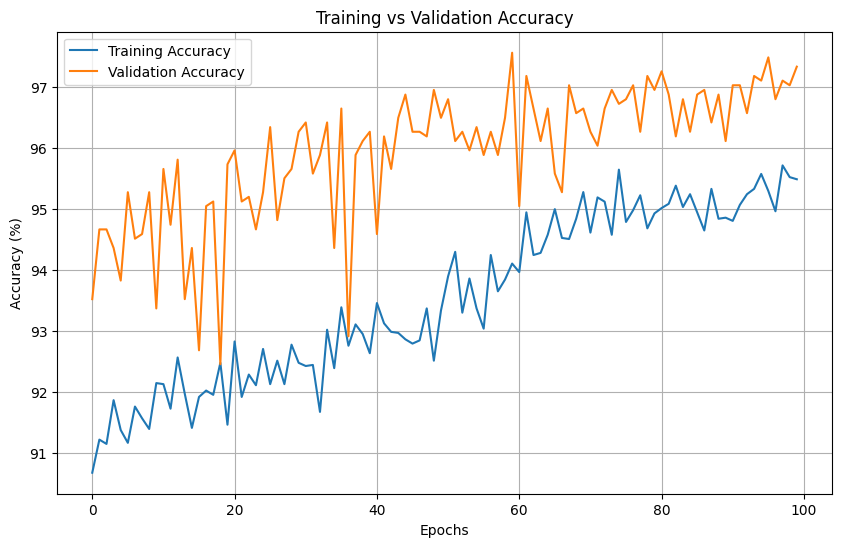

In [28]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plot Loss Graph

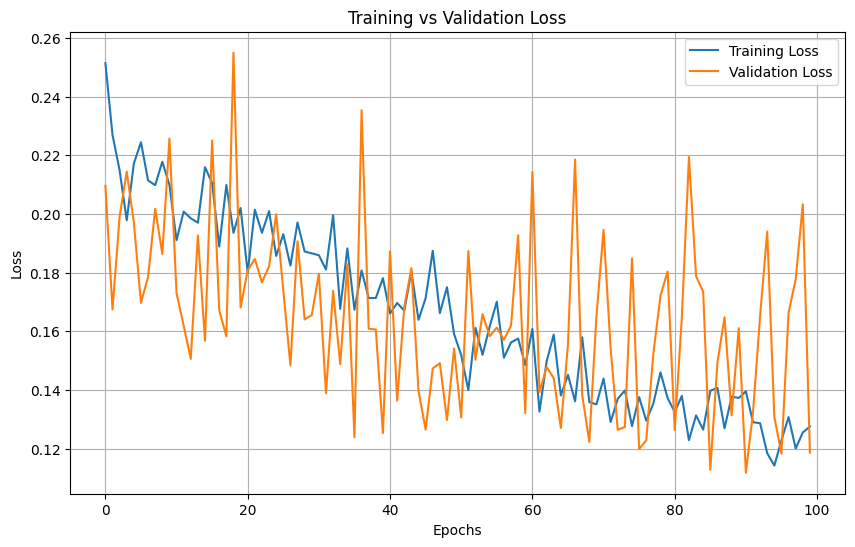

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Accuracy Test on test data

In [30]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 97.41%


Accuracy test on Test dataset

In [31]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 98.81%


In [32]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
cm = confusion_matrix(all_labels, all_preds)
cm


array([[277,  23,   0,   0],
       [  3, 296,   5,   2],
       [  0,   2, 403,   0],
       [  0,   1,   0, 299]])

<Figure size 800x600 with 0 Axes>

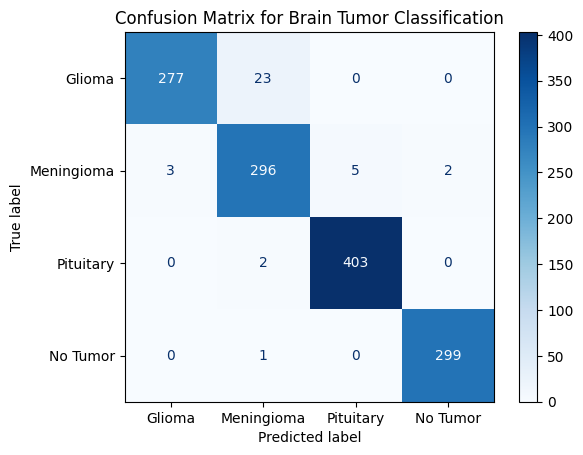

In [35]:
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Brain Tumor Classification")
plt.show()


save model

In [1]:
# Save
torch.save(model, "model_2.pth")

# # # Load
# model = torch.load("model.pth")
# model.eval()

NameError: name 'torch' is not defined

In [4]:
from PIL import Image

# Define class names (in same order as your training labels)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load models
model = torch.load("model_1.pth", map_location=torch.device('cpu'))
model.eval()

# Prediction function
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    print(f"\n🧠 Predicted Tumor Type: {classes[predicted.item()]}")
    return classes[predicted.item()]

# Example usage
# predict("sample_mri.jpg")


C:\Users\sande\AppData\Local\Temp\ipykernel_26080\3222969069.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_1.pth", map_location=torch.device(

FileNotFoundError: [Errno 2] No such file or directory: 'model_1.pth'

In [38]:
predict(r'D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Te-me_0019.jpg')



🧠 Predicted Tumor Type: meningioma


'meningioma'